In [1]:
from gs_quant.session import GsSession
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None,scopes=('read_product_data', 'run_analytics')) 

In [36]:
from gs_quant.instrument import FXOption, EqOption
from gs_quant.data import Dataset
from gs_quant.timeseries import last_value, correlation, percentiles, volatility, Returns
from gs_quant.risk import FXSpot
from gs_quant.datetime.relative_date import RelativeDate
from gs_quant.markets.portfolio import Portfolio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 2)

## EQ FX Hedging Screen

We screen for the most attractive FX options to hedge an equity index such as S&P. For each 3m FX option, we the direction is chosen based on historical 1y correlations using weekly returns. The strikes and notionals of the FX options are adjusted by the 6m realized vol ratio to an equity index. 

Realized Correlation uses weekly returns with the currency value in USD and percentile uses a 5y history. 6m realized volatility ratio uses weekly returns. Strike price is spot + FX / SPX vol ratio. Strike and Spot are in normal spot convention. Discount to SPX is FX Option premium / SPX price. Past performance is not indicative of future results. 

In [35]:
def calculate_screen(eq_ric, fx_crosses, start=RelativeDate('-5y').apply_rule(), end=RelativeDate('-1b').apply_rule()):
    fxspot_data = Dataset('WMFXSPOT').get_data(start, end, bbid=fx_crosses)
    fxspot_df = pd.pivot_table(fxspot_data, values='midPrice', index=['date'], columns=['bbid']).resample('W-FRI').last()
    eq = Dataset('TREOD').get_data(start, end, ric=eq_ric).closePrice.resample('W-FRI').last()
    eq_vol = last_value(volatility(eq, 24))
    cors = pd.DataFrame({bbid: correlation(eq, 1/fxspot_df[bbid] if bbid[0] == 'U' else fxspot_df[bbid] , 52) for bbid in fx_crosses})
    cur_cor = pd.Series(cors.tail(1).squeeze()*100, name='1y Realized Correlation (%)')
    pct_cor = pd.Series({bbid: last_value(percentiles(cors[bbid])) for bbid in fx_crosses}, name='Corr %-ile')
    vol_ = pd.DataFrame({bbid: volatility(fxspot_df[bbid], 24, Returns.LOGARITHMIC) for bbid in fx_crosses})
    vol_cur = pd.Series(vol_.tail(1).squeeze() / eq_vol , name=f'6m Realized Vol Ratio (FX / {eq_ric})')
    table = pd.concat([cur_cor, pct_cor, vol_cur ], axis=1)
    
    #price options
    eqo = EqOption(option_type='Put', underlier=eq_ric, exchange='NYSE', strike_price='90%', expiration_date='3m', buy_sell='Buy', premium=0)
    eqo.resolve()
    notional = eqo.strike_price * eqo.multiplier
    portfolio = Portfolio()
    for cross in fx_crosses:
        ratio = table.loc[cross][f'6m Realized Vol Ratio (FX / {eq_ric})']
        if cross[0] != 'U':
            cross = f'USD{cross[:3]}'
        portfolio.append(FXOption(pair=cross, option_type='Call', expiration_date='3m', strike_price=f's+{ratio*10}%', buy_sell='Buy', 
                            notional_amount=notional/ratio))
    portfolio.resolve()
    port_df = portfolio.to_frame()
    port_df['Cost in bps'] = (port_df['premium'] / port_df['notional_amount'])*1e4
    port_df[f'Discount to {eq_ric} (%)'] =(abs(port_df['premium'])/eqo.price() - 1)*100
    port_df['Spot'] = list(portfolio.calc(FXSpot).result())
    port_df['pair'] = port_df['pair'].str.replace(' ', '')
    port_df['pair_'] = g10
    port_df = port_df.set_index('pair_')
    port_df['Strike'] = [1 / port_df.loc[x]['strike_price'] if x != port_df.loc[x]['pair'] else port_df.loc[x]['strike_price'] for x in port_df.index]
    result = table.join([port_df['Strike'], port_df['Spot'],port_df['Cost in bps'],port_df[f'Discount to {eq_ric} (%)']])
    return result.sort_values(by=['1y Realized Correlation (%)', f'Discount to {eq_ric} (%)'], ascending=(False, True))

In [29]:
start = RelativeDate('-5y').apply_rule()
end = RelativeDate('-1b').apply_rule()
g10 = ['USDJPY', 'EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD', 'USDNOK', 'NZDUSD', 'USDSEK', 'USDCHF']

#example equity index rics '.FTSE','.N225','.SPX' or '.STOXX50E'
eq_ric = '.N225'
table = calculate_screen(eq_ric='.N225', fx_crosses=g10)
table.style.background_gradient(
        subset=['1y Realized Correlation (%)', f'Discount to {eq_ric} (%)'])

,1y Realized Correlation (%),Corr %-ile,6m Realized Vol Ratio (FX / .N225),Strike,Spot,Cost in bps,Discount to .N225 (%)
AUDUSD,73.22,80.71,0.67,0.72,0.77,-34.22,-67.38
USDNOK,69.65,82.62,0.94,9.31,8.51,-36.53,-75.05
USDCAD,69.50,83.57,0.41,1.33,1.28,-24.64,-60.91
NZDUSD,67.38,90.71,0.57,0.68,0.72,-44.89,-49.14
GBPUSD,58.75,87.86,0.58,1.30,1.37,-18.03,-79.88
USDSEK,58.53,78.81,0.69,8.97,8.39,-22.40,-79.09
EURUSD,50.30,86.43,0.45,1.15,1.20,-10.95,-84.34
USDCHF,41.07,87.38,0.46,0.94,0.90,-9.08,-87.23
USDJPY,15.11,99.76,0.33,108.65,105.18,-17.39,-66.10


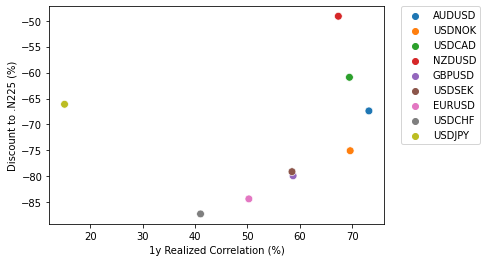

In [34]:
sns.scatterplot(x=table['1y Realized Correlation (%)'], y=table[f'Discount to {eq_ric} (%)'], hue=table.index, s=60)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)